<a href="https://colab.research.google.com/github/saadAwd/Kaggle/blob/main/j1QrgYhN2FKjNvAw/j1QrgYhN2FKjNvAw-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fake voice Detection:#

in this part of the project we will be using the cloned voices texts dataset created from the other part of the project which was the voice cloning part to be used along with random sample from cv_corpus validated dataset to train the model on classifying fake and real voices.

In [1]:
#installing spacy to be used for text embeddings

!pip install spacy

In [2]:
#installing the en_core_web_md pre trained cli
!python -m spacy download en_core_web_md


2023-10-09 04:47:00.946209: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 04:47:02.094423: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 11.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [3]:
import os
print(os.getcwd())

/content


Loading the necesseray files that was already downloaded or created earlier in the project tht is required to train the text embeddings models.

files to be loaded:
*   validated.tsv
*   cloned_df.csv
*   real_features.csv
*   fake_features (1).csv
*   real_embedded_vectors.csv
*   fake_embedded_vectors.csv









In [8]:
from google.colab import files
uploaded = files.upload()

Saving cloned_df.csv to cloned_df.csv
Saving fake_embedded_vectors.npy to fake_embedded_vectors.npy
Saving fake_features (1).csv to fake_features (1).csv
Saving real_embedded_vectors.csv to real_embedded_vectors.csv
Saving real_features.csv to real_features.csv


in the below cell we are makeing a randomly created real voices text subset that match the cloned voices df to be at the same sahpe

In [5]:
import pandas as pd



# Define the file paths
original_file_path = "/content/validated.tsv"
new_file_path = "/content/sampled_real_voices.tsv"

# Read the original dataset
df_original = pd.read_csv(original_file_path, delimiter='\t')

# Randomly select 165 rows from the original dataset
df_sampled = df_original.sample(n=165, random_state=42)  # Adjust the random_state if needed

# Save the sampled dataset to a new file
df_sampled.to_csv(new_file_path, sep='\t', index=False)

below cell is creating text embeddings using spaCy for real voices

In [6]:
import csv
import spacy
from itertools import islice

# Load the pre-trained word embeddings model
nlp = spacy.load("en_core_web_md")

# Path to the "other" TSV file containing the MP3 paths and sentences
sampled_file_path = "/content/sampled_real_voices.tsv"

# Batch size for processing sentences
batch_size = 100

# List to store the embedded vectors
embedded_vectors = []

# Read the TSV file in chunks
with open(sampled_file_path, "r") as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')

    for chunk in iter(lambda: list(islice(reader, batch_size)), []):
        mp3_paths = []
        sentences = []

        for row in chunk:
            if len(row) >= 2:
                mp3_paths.append(row[1].strip())
                sentences.append(row[2].strip())

        # Perform text embedding on the sentences
        for sentence in sentences:
            doc = nlp(sentence)

            # Access the embedded vectors
            for token in doc:
                embedded_vectors.append(token.vector)

        # Perform text embedding on the MP3 paths
        for mp3_path in mp3_paths:
            doc = nlp(mp3_path)

            # Access the embedded vectors
            for token in doc:
                embedded_vectors.append(token.vector)

# Save the embedded vectors to a CSV file
output_file = "/content/real_embedded_vectors.npy"  # Update with the desired output file path

with open(output_file, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(embedded_vectors)

Creating text embeddings using spaCy for fake voices

In [9]:
import pandas as pd
import spacy
import numpy as np

# Load the pre-trained word embeddings model
nlp = spacy.load("en_core_web_md")

# Path to the CSV file containing the fake voice data
fake_voices_file_path = "/content/cloned_df.csv"

# Batch size for processing sentences
batch_size = 100

# List to store the embedded vectors
embedded_vectors = []

# Read the CSV file in chunks
for chunk in pd.read_csv(fake_voices_file_path, chunksize=batch_size):
    # Extract the sentences from the chunk
    sentences = chunk["text"].tolist()

    # Perform text embedding on the sentences
    for sentence in sentences:
        # Perform text embedding on the sentence
        doc = nlp(sentence)

        # Access the embedded vectors
        for token in doc:
            embedded_vectors.append(token.vector)

# Convert the list of embedded vectors to a NumPy array
embedded_vectors = np.array(embedded_vectors)

# Save the embedded vectors to a file
output_file_path = "/content/fake_embedded_vectors.csv"  # Update with the desired output file path
np.save(output_file_path, embedded_vectors)

creating the label coulmn for both datasets, real voices labe; = 0, fake voices label = 1 then concatinating both datasets to make it redy for training the classifier

# New Section

In [10]:
import pandas as pd
import numpy as np

# Load real voice text embeddings
real_data = pd.read_csv('/content/real_embedded_vectors.csv')

# Load fake voice text embeddings from .npy file
fake_data = np.load('/content/fake_embedded_vectors.npy')

# Check the number of columns in real and fake data
if real_data.shape[1] != fake_data.shape[1]:
    print("Real data shape:", real_data.shape)
    print("Fake data shape:", fake_data.shape)
    raise ValueError("Number of columns in real and fake data do not match.")

# Duplicate the fake data to match the number of rows in the real data
num_duplicates = real_data.shape[0] // fake_data.shape[0]
fake_data = np.tile(fake_data, (num_duplicates, 1))

# Truncate the duplicated fake data to match the number of rows in the real data
num_extra_rows = real_data.shape[0] % fake_data.shape[0]
fake_data = np.concatenate((fake_data, fake_data[:num_extra_rows]), axis=0)

# Create a DataFrame for fake voice embeddings
fake_data = pd.DataFrame(fake_data, columns=real_data.columns)

# Add a column 'label' to indicate the class (0 for real, 1 for fake)
real_data['label'] = 0
fake_data['label'] = 1

# Concatenate the real and fake data
data = pd.concat([real_data, fake_data], ignore_index=True)

# Separate the features (text embeddings) and the target variable
X = data.drop('label', axis=1)
y = data['label']



logistic regression classifier trained on datset made by spaCy embeddings

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a logistic regression classifier with increased max_iter
logreg = LogisticRegression(max_iter=1000)  # Set max_iter to your desired value
logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 66.11%


In [12]:
#installing transformer module to use bert text embeddings
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.6 MB/s eta 0:00:00


In [13]:
#installing transformer module to use gloVe text embeddings
!pip install gensim

In [14]:
#importing the required models
from gensim.models import KeyedVectors
from transformers import BertTokenizer, BertModel

here we will load glove pretrained model and unzip it to make reay for use

In [15]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
!unzip '/content/drive/MyDrive/Colab Notebooks/glove.6B.zip' -d /content/gloVe6B

Archive:  /content/drive/MyDrive/Colab Notebooks/glove.6B.zip
  inflating: /content/gloVe6B/glove.6B.50d.txt  
  inflating: /content/gloVe6B/glove.6B.100d.txt  
  inflating: /content/gloVe6B/glove.6B.200d.txt  
  inflating: /content/gloVe6B/glove.6B.300d.txt  


In [17]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

glove_path = '/content/gloVe6B/glove.6B.100d.txt'
word2vec_output_path = '/content/gloVe6B/glove.6B.100d.word2vec.txt'

# Convert GloVe to Word2Vec format
glove2word2vec(glove_path, word2vec_output_path)

# Load the Word2Vec embeddings
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_path, binary=False)

<ipython-input-17-02cc05f28b2f>:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_path, word2vec_output_path)


In [18]:

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Initialize the BERT model
bert_model = BertModel.from_pretrained('bert-base-uncased')

below step is extracting the text columns form both dataset to be used as trancripted text for both models

In [19]:
cloned_text_to_df = pd.read_csv('cloned_df.csv')

# Extract the 'text' column
cloned_texts = cloned_text_to_df['text'].tolist()
real_text = df_sampled['sentence'].tolist()



here we will create the embeddings for the cloned voices dataset for both bert and glove

In [20]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel

# Load the transcribed text data from the source you used for training
transcribed_texts_cloned = cloned_texts


# GloVe Embeddings
glove_embeddings = []

for transcribed_text_cloned in transcribed_texts_cloned:
    tokens = transcribed_text_cloned.split()
    text_embedding = np.mean([glove_model[t] for t in tokens if t in glove_model], axis=0)
    glove_embeddings.append(text_embedding)

# Filter out empty or NaN embeddings
glove_embeddings = [embedding for embedding in glove_embeddings if embedding is not None and not np.isnan(embedding).any()]

# Convert the embeddings to a DataFrame
glove_embeddings_df_cloned = pd.DataFrame(glove_embeddings)

# BERT Embeddings
bert_embeddings = []

for transcribed_text_cloned in transcribed_texts_cloned:
    inputs = tokenizer.encode_plus(transcribed_text_cloned, add_special_tokens=True, return_tensors='pt')
    outputs = bert_model(**inputs)
    text_embedding = torch.mean(outputs.last_hidden_state, dim=1).squeeze().detach().numpy()
    bert_embeddings.append(text_embedding)

bert_embeddings_df_cloned = pd.DataFrame(bert_embeddings)

here we will create the embeddings for the real voices dataset for both bert and glove

In [21]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel

# Load the transcribed text data from the source you used for training
transcribed_texts_real = real_text


# GloVe Embeddings
glove_embeddings = []

for transcribed_text_real in transcribed_texts_real:
    tokens = transcribed_text_real.split()
    text_embedding = np.mean([glove_model[t] for t in tokens if t in glove_model], axis=0)
    glove_embeddings.append(text_embedding)

# Filter out empty or NaN embeddings
glove_embeddings = [embedding for embedding in glove_embeddings if embedding is not None and not np.isnan(embedding).any()]

# Convert the embeddings to a DataFrame
glove_embeddings_df_real = pd.DataFrame(glove_embeddings)

# BERT Embeddings
bert_embeddings = []

for transcribed_text_real in transcribed_texts_real:
    inputs = tokenizer.encode_plus(transcribed_text_real, add_special_tokens=True, return_tensors='pt')
    outputs = bert_model(**inputs)
    text_embedding = torch.mean(outputs.last_hidden_state, dim=1).squeeze().detach().numpy()
    bert_embeddings.append(text_embedding)

bert_embeddings_df_real = pd.DataFrame(bert_embeddings)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


**Logistic regression:**

at this part we will train logistic regression classifier on the three embeddings techniques

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Add a column 'label' to indicate the class (0 for real, 1 for fake)
bert_embeddings_df_real['label'] = 0
bert_embeddings_df_cloned['label'] = 1

# Concatenate the real and fake data
bert_data = pd.concat([bert_embeddings_df_real, bert_embeddings_df_cloned], ignore_index=True)

# Separate the features (text embeddings) and the target variable
Xbert = bert_data.drop('label', axis=1)
ybert = bert_data['label']
# Split the data into training and testing sets
Xbert_train, Xbert_test, ybert_train, ybert_test = train_test_split(Xbert, ybert, test_size=0.2, random_state=42)

# Initialize and train a logistic regression classifier with increased max_iter
logreg_bert = LogisticRegression(max_iter=1000)  # Set max_iter to your desired value
logreg_bert.fit(Xbert_train, ybert_train)

# Make predictions on the test set
y_pred_bert = logreg_bert.predict(Xbert_test)

# Evaluate the accuracy of the classifier for BERT
accuracy_bert = accuracy_score(ybert_test, y_pred_bert)
print("Logistic regression classifier Accuracy Results")
print("Accuracy for BERT: {:.2f}%".format(accuracy_bert * 100))

# Add a column 'label' to indicate the class (0 for real, 1 for fake)
glove_embeddings_df_real['label'] = 0
glove_embeddings_df_cloned['label'] = 1

# Concatenate the real and fake data
glove_data = pd.concat([glove_embeddings_df_real, glove_embeddings_df_cloned], ignore_index=True)

# Separate the features (text embeddings) and the target variable
Xglove = glove_data.drop('label', axis=1)
yglove = glove_data['label']
# Split the data into training and testing sets
Xglove_train, Xglove_test, yglove_train, yglove_test = train_test_split(Xglove, yglove, test_size=0.2, random_state=42)

# Initialize and train a logistic regression classifier with increased max_iter for Glove
logreg_glove = LogisticRegression(max_iter=1000)  # Set max_iter to your desired value
logreg_glove.fit(Xglove_train, yglove_train)

# Make predictions on the test set for Glove
y_pred_glove = logreg_glove.predict(Xglove_test)

# Evaluate the accuracy of the classifier for Glove
accuracy_glove = accuracy_score(yglove_test, y_pred_glove)
print("Accuracy for GloVe: {:.2f}%".format(accuracy_glove * 100))
print("Accuracy for spaCy: {:.2f}%".format(accuracy * 100))

Logistic regression classifier Accuracy Results
Accuracy for BERT: 86.36%
Accuracy for GloVe: 69.70%
Accuracy for spaCy: 66.11%


**Decsion Tree:**

at this part we will train Decsion Tree classifier on the three embeddings techniques

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialize and train a decision tree classifier
dt_classifier_bert = DecisionTreeClassifier()
dt_classifier_bert.fit(Xbert_train, ybert_train)

# Make predictions on the test set
y_pred_dt_bert = dt_classifier_bert.predict(Xbert_test)

# Evaluate the accuracy of the decision tree classifier for BERT
accuracy_dt_bert = accuracy_score(ybert_test, y_pred_dt_bert)
print("Decision Tree Classifier Accuracy Results")
print("Accuracy for BERT: {:.2f}%".format(accuracy_dt_bert * 100))

# Initialize and train a decision tree classifier
dt_classifier_glove = DecisionTreeClassifier()
dt_classifier_glove.fit(Xglove_train, yglove_train)

# Make predictions on the test set
y_pred_dt_glove = dt_classifier_glove.predict(Xglove_test)

# Evaluate the accuracy of the decision tree classifier for Glove
accuracy_dt_glove = accuracy_score(yglove_test, y_pred_dt_glove)
print("Accuracy for GloVe: {:.2f}%".format(accuracy_dt_glove * 100))

# Initialize and train a decision tree classifier
dt_classifier_spacy = DecisionTreeClassifier()
dt_classifier_spacy.fit(X_train, y_train)

# Make predictions on the test set
y_pred_dt_spacy = dt_classifier_spacy.predict(X_test)

# Evaluate the accuracy of the decision tree classifier for spaCy
accuracy_dt_spacy = accuracy_score(y_test, y_pred_dt_spacy)
print("Accuracy for SpaCy: {:.2f}%".format(accuracy_dt_spacy * 100))

Decision Tree Classifier Accuracy Results
Accuracy for BERT: 75.76%
Accuracy for GloVe: 62.12%
Accuracy for SpaCy: 70.02%


**XGboost:**

at this part we will train XGboost classifier on the three embeddings techniques

In [24]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Initialize and train an XGBoost classifier for BERT
xgb_classifier_bert = xgb.XGBClassifier()
xgb_classifier_bert.fit(Xbert_train, ybert_train)

# Make predictions on the test set
y_pred_xgb_bert = xgb_classifier_bert.predict(Xbert_test)

# Evaluate the accuracy of the XGBoost classifier for BERT
accuracy_xgb_bert = accuracy_score(ybert_test, y_pred_xgb_bert)
print("XGBoost Classifier Accuracy Results")
print("Accuracy for BERT: {:.2f}%".format(accuracy_xgb_bert * 100))

# Initialize and train an XGBoost classifier for GloVe
xgb_classifier_glove = xgb.XGBClassifier()
xgb_classifier_glove.fit(Xglove_train, yglove_train)

# Make predictions on the test set
y_pred_xgb_glove = xgb_classifier_glove.predict(Xglove_test)

# Evaluate the accuracy of the XGBoost classifier for GloVe
accuracy_xgb_glove = accuracy_score(yglove_test, y_pred_xgb_glove)
print("Accuracy for GloVe: {:.2f}%".format(accuracy_xgb_glove * 100))

# Initialize and train an XGBoost classifier for spaCy
xgb_classifier_spacy = xgb.XGBClassifier()
xgb_classifier_spacy.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb_spacy = xgb_classifier_spacy.predict(X_test)

# Evaluate the accuracy of the XGBoost classifier for spaCy
accuracy_xgb_spacy = accuracy_score(y_test, y_pred_xgb_spacy)
print("Accuracy for spaCy: {:.2f}%".format(accuracy_xgb_spacy * 100))

XGBoost Classifier Accuracy Results
Accuracy for BERT: 84.85%
Accuracy for GloVe: 66.67%
Accuracy for spaCy: 71.14%


below we will plot the result for better visualiztion and decsion making to choose the best model

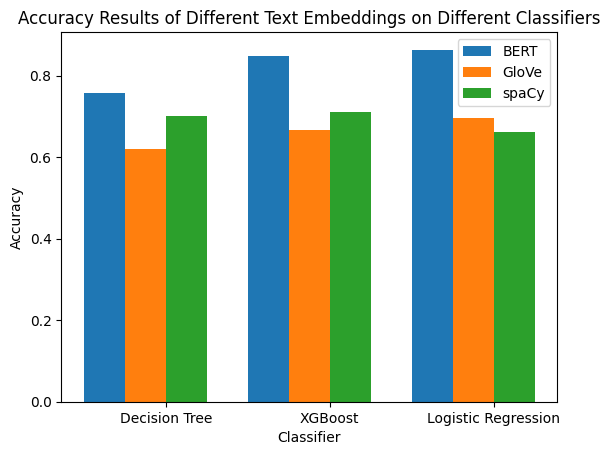

In [25]:
import matplotlib.pyplot as plt

# Accuracy results
accuracy_results = {
    'BERT': [accuracy_dt_bert, accuracy_xgb_bert, accuracy_bert],
    'GloVe': [accuracy_dt_glove, accuracy_xgb_glove, accuracy_glove],
    'spaCy': [accuracy_dt_spacy, accuracy_xgb_spacy, accuracy]
}

# Classifiers
classifiers = ['Decision Tree', 'XGBoost', 'Logistic Regression']

# Plotting the bar chart
fig, ax = plt.subplots()
bar_width = 0.25
index = np.arange(len(classifiers))

# Plotting accuracy results for each text embedding
for i, embedding in enumerate(accuracy_results.keys()):
    accuracies = accuracy_results[embedding]
    ax.bar(index + i * bar_width, accuracies, bar_width, label=embedding)

ax.set_xlabel('Classifier')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Results of Different Text Embeddings on Different Classifiers')
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(classifiers)
ax.legend()

plt.show()

as we can see BERT text embeddings on logistic regression classifer gave the best result, so it will be used as iur classifer for this prject

below we will load fake voice and real voice to be used by the modle for testing purposes

